## Block 1: Imports

In [1]:
import os
import time
import pandas as pd
import glob
import yfinance as yf
from tqdm import tqdm
import zipfile
import requests
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pandas.util import hash_pandas_object

## Block 2: Configuration

In [2]:
DATA_DIR = "full_history/full_history"
NEWS_FILES = ["All_external.csv", "nasdaq_exteral_data.csv"]
META_CACHE = "ticker_meta_yahoo.csv"
NEWS_DEDUPED = "news_deduped_2019_2023.csv"

START_DATE = pd.to_datetime("2019-01-01")
END_DATE = pd.to_datetime("2023-12-31")

TRADING_DAYS_EXPECTED = len(pd.bdate_range(START_DATE, END_DATE))
EDGE_TOLERANCE_DAYS = 31

THRESHOLD_PRICE_ROWS = 1000
THRESHOLD_NEWS_COUNT = 50
THRESHOLD_COVERAGE_PCT = 80

pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)

BASE_URL = "https://huggingface.co/datasets/Zihan1004/FNSPID/resolve/main"
CHUNKSIZE = 200_000

## Block 3: Helper Functions

In [3]:
def download_file(url, filename):
    if os.path.exists(filename) and os.path.getsize(filename) > 0:
        print(f"File already exists: {filename}")
        return
    print(f"Downloading {filename}...")
    resp = requests.get(url, stream=True)
    resp.raise_for_status()
    total_size = int(resp.headers.get("content-length", 0))
    with open(filename, "wb") as f:
        with tqdm(total=total_size, unit="B", unit_scale=True, unit_divisor=1024) as pbar:
            for chunk in resp.iter_content(1024 * 1024):
                if chunk:
                    f.write(chunk)
                    pbar.update(len(chunk))
    print(f"Done: {filename}")

def normalize_ticker_for_yahoo(ticker):
    return str(ticker).replace(".", "-").strip()

def get_company_metadata(ticker):
    symbol = normalize_ticker_for_yahoo(ticker)
    try:
        info = yf.Ticker(symbol).get_info()
        return {
            "ticker": str(ticker),
            "yahoo_symbol": symbol,
            "company_name": info.get("longName") or info.get("shortName"),
            "sector": info.get("sector"),
            "industry": info.get("industry"),
            "exchange": info.get("exchange"),
            "quoteType": info.get("quoteType")
        }
    except Exception:
        return {
            "ticker": str(ticker), "yahoo_symbol": symbol,
            "company_name": None, "sector": None, "industry": None,
            "exchange": None, "quoteType": None
        }
    finally:
        time.sleep(0.25)

def load_or_create_meta_cache(path):
    if os.path.exists(path) and os.path.getsize(path) > 0:
        try:
            return pd.read_csv(path)
        except Exception:
            pass
    return pd.DataFrame(columns=[
        "ticker", "yahoo_symbol", "company_name",
        "sector", "industry", "exchange", "quoteType"
    ])

def fetch_missing_metadata(tickers, cache_path):
    cache = load_or_create_meta_cache(cache_path)
    cached_tickers = set(cache["ticker"].astype(str))
    missing = [t for t in tickers if str(t) not in cached_tickers]
    print(f"Cached: {len(cached_tickers)}, to fetch: {len(missing)}")
    if missing:
        new_records = [get_company_metadata(t) for t in tqdm(missing, desc="Fetching Yahoo metadata")]
        cache = pd.concat([cache, pd.DataFrame(new_records)], ignore_index=True)
        cache = cache.drop_duplicates(subset=["ticker"], keep="last")
        cache.to_csv(cache_path, index=False)
        print(f"Cache saved: {cache_path}")
    return cache

def aggregate_news_statistics(file_paths, valid_tickers, chunksize=200_000):
    counts, min_dates, max_dates = {}, {}, {}
    for filepath in file_paths:
        for chunk in tqdm(pd.read_csv(filepath, chunksize=chunksize, low_memory=False),
                         desc=f"Processing {os.path.basename(filepath)}"):
            chunk = chunk.rename(columns={"Date": "date", "Stock_symbol": "ticker"})
            if "date" not in chunk.columns or "ticker" not in chunk.columns:
                continue
            chunk["date"] = pd.to_datetime(
                chunk["date"], errors="coerce", utc=True
            ).dt.tz_convert(None).dt.normalize()
            chunk = chunk.dropna(subset=["date", "ticker"])
            chunk = chunk[(chunk["date"] >= START_DATE) & (chunk["date"] <= END_DATE)]
            chunk["ticker"] = chunk["ticker"].astype(str).str.strip()
            chunk = chunk[chunk["ticker"].isin(valid_tickers)]
            if chunk.empty:
                continue
            grouped = chunk.groupby("ticker")["date"].agg(["count", "min", "max"])
            for ticker, row in grouped.iterrows():
                counts[ticker] = counts.get(ticker, 0) + int(row["count"])
                min_dates[ticker] = row["min"] if ticker not in min_dates else min(min_dates[ticker], row["min"])
                max_dates[ticker] = row["max"] if ticker not in max_dates else max(max_dates[ticker], row["max"])
    return pd.DataFrame({
        "ticker": list(counts.keys()),
        "news_count": [counts[t] for t in counts],
        "news_min_date": [min_dates[t] for t in counts],
        "news_max_date": [max_dates[t] for t in counts]
    })

def analyze_price_coverage(data_dir, start, end, expected_days,
                           edge_tolerance_days=31, max_errors=10):
    files = [f for f in os.listdir(data_dir) if f.endswith(".csv")]
    results = []
    errors = []

    for filename in tqdm(files, desc="Analyzing price coverage"):
        ticker = filename[:-4]
        try:
            df = pd.read_csv(os.path.join(data_dir, filename), low_memory=False)

            df["date"] = pd.to_datetime(df["date"], errors="coerce").dt.normalize()
            df = df.dropna(subset=["date"])
            df = df[(df["date"] >= start) & (df["date"] <= end)]
            if df.empty:
                continue

            df = df.drop_duplicates(subset=["date"])
            n_days = int(df["date"].nunique())
            date_min, date_max = df["date"].min(), df["date"].max()

            coverage = n_days / expected_days * 100
            starts_ok = date_min <= (start + pd.Timedelta(days=edge_tolerance_days))
            ends_ok = date_max >= (end - pd.Timedelta(days=edge_tolerance_days))

            results.append({
                "ticker": ticker,
                "price_rows": n_days,
                "price_min_date": date_min,
                "price_max_date": date_max,
                "coverage_pct": round(coverage, 1),
                "starts_in_2019": starts_ok,
                "ends_in_2023": ends_ok,
                "full_coverage": bool(starts_ok and ends_ok)
            })

        except Exception as e:
            if len(errors) < max_errors:
                errors.append((ticker, str(e)))
            continue

    if errors:
        print(f"Read errors: {len(errors)} "
              f"(showing first {min(len(errors), max_errors)})")
        for t, msg in errors[:max_errors]:
            print(f"  - {t}: {msg}")

    return pd.DataFrame(results)

def apply_quality_filters(df, min_rows, min_news, min_coverage):
    return (
        df["full_coverage"]
        & (df["price_rows"] >= min_rows)
        & (df["news_count"] >= min_news)
        & (df["coverage_pct"] >= min_coverage)
    )

def print_summary(df, title):
    line = "=" * 60
    print("\n" + line)
    print(title)
    print(line)
    print(f"Total companies: {len(df)}")
    print(f"Period: {START_DATE.date()} — {END_DATE.date()}")
    if len(df) > 0:
        if "price_rows" in df.columns:
            print(f"Avg trading days with prices: {df['price_rows'].mean():.0f}")
            print(f"Min/max trading days: {df['price_rows'].min():.0f} / {df['price_rows'].max():.0f}")
        if "news_count" in df.columns:
            print(
                f"News per company — mean: {df['news_count'].mean():.0f}, "
                f"median: {df['news_count'].median():.0f}, "
                f"range: [{df['news_count'].min()}, {df['news_count'].max()}]"
            )
            
def deduplicate_news_files(file_paths, output_path, chunksize=200_000):
    if os.path.exists(output_path) and os.path.getsize(output_path) > 0:
        print(f"Deduplicated file already exists: {output_path}")
        return output_path

    TEXT_FIELDS = ["Article_title", "Article", "Lsa_summary",
                   "Luhn_summary", "Textrank_summary", "Lexrank_summary"]

    def _make_hash(df):
        url = df["Url"].astype(str).str.strip().str.lower().values
        ticker = df["Stock_symbol"].astype(str).str.strip().str.upper().values
        return np.array([hash(u + "||" + t) for u, t in zip(url, ticker)],
                        dtype="int64")

    source_hashes = {}
    source_fill = {}

    for filepath in file_paths:
        tag = os.path.basename(filepath)
        hashes = set()
        filled_sum = 0
        n_rows = 0

        for chunk in tqdm(pd.read_csv(filepath, chunksize=chunksize, low_memory=False),
                          desc=f"Scanning {tag}"):
            n_rows += len(chunk)
            h = _make_hash(chunk)
            hashes.update(h.tolist())
            for col in TEXT_FIELDS:
                if col in chunk.columns:
                    filled_sum += chunk[col].notna().sum()

        mean_fill = filled_sum / max(n_rows, 1)
        source_hashes[filepath] = hashes
        source_fill[filepath] = mean_fill
        print(f"  {tag}: {n_rows:,} rows, {len(hashes):,} unique hashes, "
              f"mean text fields filled: {mean_fill:.2f}")

    paths = list(file_paths)
    if len(paths) == 2:
        overlap = len(source_hashes[paths[0]] & source_hashes[paths[1]])
        print(f"Hash overlap between sources: {overlap:,}")

    preferred = max(file_paths, key=lambda p: source_fill[p])
    others = [p for p in file_paths if p != preferred]
    preferred_keys = source_hashes[preferred]
    print(f"Preferred source: {os.path.basename(preferred)} "
          f"(mean fill {source_fill[preferred]:.2f})")

    all_contained = all(
        source_hashes[p].issubset(preferred_keys)
        for p in others
    )

    pref_n_rows = sum(
        len(ch) for ch in pd.read_csv(preferred, chunksize=chunksize,
                                       usecols=["Url", "Stock_symbol"],
                                       low_memory=False)
    )
    pref_has_internal_dupes = pref_n_rows != len(preferred_keys)

    if all_contained and not pref_has_internal_dupes:
        print(f"All other sources are subsets of {os.path.basename(preferred)}, "
              f"no internal duplicates. Using preferred source directly.")
        return preferred

    if all_contained:
        print(f"{os.path.basename(preferred)} has "
              f"~{pref_n_rows - len(preferred_keys):,} internal duplicates. "
              f"Writing deduplicated file...")

    header_written = False
    total_written = 0
    seen_hashes = set()

    for chunk in tqdm(pd.read_csv(preferred, chunksize=chunksize, low_memory=False),
                      desc=f"Writing {os.path.basename(preferred)}"):
        h = _make_hash(chunk)
        mask = ~np.isin(h, np.array(list(seen_hashes), dtype="int64")) if seen_hashes else np.ones(len(h), dtype=bool)
        seen_hashes.update(h[mask].tolist())
        deduped = chunk[mask]
        if len(deduped) > 0:
            deduped.to_csv(output_path, mode="a", index=False, header=not header_written)
            header_written = True
            total_written += len(deduped)

    added_from_others = 0
    if not all_contained:
        for filepath in others:
            for chunk in tqdm(pd.read_csv(filepath, chunksize=chunksize, low_memory=False),
                              desc=f"Filtering {os.path.basename(filepath)}"):
                h = _make_hash(chunk)
                mask = ~np.isin(h, np.array(list(seen_hashes), dtype="int64"))
                new_rows = chunk[mask]
                if len(new_rows) > 0:
                    new_rows.to_csv(output_path, mode="a", index=False, header=False)
                    added_from_others += len(new_rows)
                    total_written += len(new_rows)

    print(f"Done: {total_written:,} rows written to {output_path}")
    if added_from_others > 0:
        print(f"  (added {added_from_others:,} unique rows from non-preferred sources)")
    return output_path

def print_step(title):
    line = "=" * 60
    print(line)
    print(title)
    print(line)

## Block 4: Data Download

In [4]:
print_step("STEP 0: Downloading and preparing data")
news_files_download = {
    "All_external.csv": "Stock_news/All_external.csv",
    "nasdaq_exteral_data.csv": "Stock_news/nasdaq_exteral_data.csv",
}

for local_name, remote_path in news_files_download.items():
    download_file(f"{BASE_URL}/{remote_path}", local_name)

zip_filename = "full_history.zip"
download_file(f"{BASE_URL}/Stock_price/full_history.zip", zip_filename)

target_dir = os.path.join("full_history", "full_history")
has_prices = os.path.isdir(target_dir) and len(glob.glob(os.path.join(target_dir, "*.csv"))) > 0

if not has_prices:
    print("Extracting full_history.zip...")
    with zipfile.ZipFile(zip_filename, "r") as z:
        z.extractall("full_history")
    print("Done: data extracted to full_history/")
else:
    print("Price data directory already exists and is not empty: skipping extraction")

print_step("STEP 0.5: Deduplicating news files")
NEWS_DEDUPED = deduplicate_news_files(NEWS_FILES, NEWS_DEDUPED, chunksize=CHUNKSIZE)

STEP 0: Downloading and preparing data
File already exists: All_external.csv
File already exists: nasdaq_exteral_data.csv
File already exists: full_history.zip
Price data directory already exists and is not empty: skipping extraction
STEP 0.5: Deduplicating news files


Scanning All_external.csv: 66it [00:48,  1.36it/s]


  All_external.csv: 13,057,514 rows, 13,033,267 unique hashes, mean text fields filled: 1.10


Scanning nasdaq_exteral_data.csv: 78it [02:27,  1.90s/it]


  nasdaq_exteral_data.csv: 15,549,299 rows, 15,521,842 unique hashes, mean text fields filled: 1.88
Hash overlap between sources: 13,033,267
Preferred source: nasdaq_exteral_data.csv (mean fill 1.88)
nasdaq_exteral_data.csv has ~27,457 internal duplicates. Writing deduplicated file...


Writing nasdaq_exteral_data.csv: 78it [07:29,  5.76s/it]

Done: 15,536,796 rows written to news_deduped_2019_2023.csv


## Block 5: Main Pipeline

In [5]:
PRICE_CACHE = "cache_price_coverage_2019_2023.csv"
NEWS_CACHE = "cache_news_stats_2019_2023.csv"

In [6]:
print_step("STEP 1: Analyzing price data coverage (2019-2023)")

if os.path.exists(PRICE_CACHE):
    price_data = pd.read_csv(PRICE_CACHE, parse_dates=["price_min_date", "price_max_date"])
else:
    price_data = analyze_price_coverage(
        DATA_DIR, START_DATE, END_DATE, TRADING_DAYS_EXPECTED,
        edge_tolerance_days=EDGE_TOLERANCE_DAYS
    )
    price_data.to_csv(PRICE_CACHE, index=False)

print(f"Tickers with price data in period: {len(price_data)}")
print(f"Tickers with full coverage (with tolerance): {int(price_data['full_coverage'].sum())}")

print_step("STEP 2: Aggregating news statistics (2019-2023)")

valid_tickers = set(price_data["ticker"].astype(str))

if os.path.exists(NEWS_CACHE):
    news_data = pd.read_csv(NEWS_CACHE, parse_dates=["news_min_date", "news_max_date"])
else:
    news_data = aggregate_news_statistics([NEWS_DEDUPED], valid_tickers, chunksize=CHUNKSIZE)
    news_data.to_csv(NEWS_CACHE, index=False)

print(f"Tickers with news in period: {len(news_data)}")

print_step("STEP 3: Merging and filtering data")

combined = price_data.merge(news_data, on="ticker", how="inner")
combined["passes_filters"] = apply_quality_filters(
    combined, THRESHOLD_PRICE_ROWS, THRESHOLD_NEWS_COUNT, THRESHOLD_COVERAGE_PCT
)

print(f"Tickers with both prices and news (after merge): {len(combined)}")
print(f"Tickers passing all quality filters: {int(combined['passes_filters'].sum())}")

print_step("STEP 4: Enriching with company metadata (Yahoo Finance)")

filtered = combined[combined["passes_filters"]].sort_values("news_count", ascending=False)
metadata = fetch_missing_metadata(filtered["ticker"].tolist(), META_CACHE)

final_dataset = filtered.merge(
    metadata[["ticker", "company_name", "sector", "industry", "exchange", "quoteType"]],
    on="ticker", how="left"
)

output_columns = [
    "ticker", "company_name", "sector", "industry", "exchange", "quoteType",
    "price_rows", "price_min_date", "price_max_date", "coverage_pct",
    "starts_in_2019", "ends_in_2023", "full_coverage",
    "news_count", "news_min_date", "news_max_date"
]
final_dataset = final_dataset[output_columns].reset_index(drop=True)

quality_report = pd.DataFrame([
    ["Tickers with prices in period", len(price_data)],
    ["Tickers with full coverage (with tolerance)", int(price_data["full_coverage"].sum())],
    ["Tickers with news in period", len(news_data)],
    ["Tickers after merge (inner join)", len(combined)],
    ["Tickers after quality filters", int(combined["passes_filters"].sum())],
    ["Final sample", len(final_dataset)],
    ["Final sample: EQUITY only", int((final_dataset["quoteType"] == "EQUITY").sum())],
], columns=["Stage", "Count"])

quality_report.to_csv("data_quality_report.csv", index=False)
quality_report

STEP 1: Analyzing price data coverage (2019-2023)


Analyzing price coverage: 100%|████████████| 7693/7693 [00:29<00:00, 258.21it/s]


Tickers with price data in period: 7691
Tickers with full coverage (with tolerance): 4068
STEP 2: Aggregating news statistics (2019-2023)


Processing news_deduped_2019_2023.csv: 78it [02:37,  2.02s/it]

Tickers with news in period: 5790
STEP 3: Merging and filtering data
Tickers with both prices and news (after merge): 5790
Tickers passing all quality filters: 2800
STEP 4: Enriching with company metadata (Yahoo Finance)
Cached: 2977, to fetch: 0


,Stage,Count
0,Tickers with prices in period,7691
1,Tickers with full coverage (with tolerance),4068
2,Tickers with news in period,5790
3,Tickers after merge (inner join),5790
4,Tickers after quality filters,2800
5,Final sample,2800
6,Final sample: EQUITY only,2086


## Block 6.1: Saving Ticker-Level Results

In [7]:
print_step("STEP 5: Saving results")

final_dataset.to_csv("selected_companies_2019_2023.csv", index=False)
print("Saved: selected_companies_2019_2023.csv")

equities = final_dataset[final_dataset["quoteType"] == "EQUITY"].copy()
equities.to_csv("selected_equities_only_2019_2023.csv", index=False)
print(f"Saved: selected_equities_only_2019_2023.csv (equities: {len(equities)})")

pd.DataFrame({"ticker": final_dataset["ticker"]}).to_csv("selected_tickers.csv", index=False)
print("Saved: selected_tickers.csv")

print_summary(final_dataset, "FINAL SAMPLE SUMMARY")

print("\nInstrument type (quoteType):")
print(final_dataset["quoteType"].value_counts().to_string())

print("\nSectors (top 10):")
print(final_dataset["sector"].value_counts().head(10).to_string())

print("\nExchanges:")
print(final_dataset["exchange"].value_counts().to_string())

print_step("Top 10 companies by news count")

display_cols = ["ticker", "company_name", "sector", "exchange", "price_rows", "news_count"]
display_cols_en = {
    "ticker": "Ticker",
    "company_name": "Company",
    "sector": "Sector",
    "exchange": "Exchange",
    "price_rows": "Trading Days",
    "news_count": "News Count"
}
top10 = final_dataset[display_cols].head(10).rename(columns=display_cols_en)
print(top10.to_string(index=False))

STEP 5: Saving results
Saved: selected_companies_2019_2023.csv
Saved: selected_equities_only_2019_2023.csv (equities: 2086)
Saved: selected_tickers.csv

FINAL SAMPLE SUMMARY
Total companies: 2800
Period: 2019-01-01 — 2023-12-31
Avg trading days with prices: 1257
Min/max trading days: 1049 / 1257
News per company — mean: 552, median: 230, range: [50, 10587]

Instrument type (quoteType):
quoteType
EQUITY        2086
ETF            468
NONE           209
MUTUALFUND       1

Sectors (top 10):
sector
Financial Services        450
Healthcare                299
Industrials               272
Technology                268
Consumer Cyclical         222
Energy                    124
Real Estate               116
Basic Materials           101
Consumer Defensive         87
Communication Services     81

Exchanges:
exchange
NYQ    1070
NMS     602
PCX     331
NGM     237
NCM     194
ASE      59
BTS      40
PNK      18
OQB       3
OQX       1
Top 10 companies by news count
Ticker                     

## Block 6.2: Saving Price-Level Results

In [8]:
tickers = pd.read_csv("selected_equities_only_2019_2023.csv")["ticker"].astype(str).unique().tolist()

summaries = []
skipped = []

for t in tickers:
    fp = os.path.join(DATA_DIR, f"{t}.csv")
    if not os.path.exists(fp):
        skipped.append((t, "missing_file"))
        continue

    df = pd.read_csv(fp, low_memory=False)

    df["date"] = pd.to_datetime(df["date"], errors="coerce").dt.normalize()
    df = df.dropna(subset=["date"])
    df = df[(df["date"] >= START_DATE) & (df["date"] <= END_DATE)]
    df = df.drop_duplicates(subset=["date"])

    n_days = int(df["date"].nunique())
    if n_days == 0:
        skipped.append((t, "no_dates_in_range"))
        continue

    if "adj close" in df.columns:
        price = pd.to_numeric(df["adj close"], errors="coerce")
        price_col = "adj close"

    vol_col = "volume"

    volume = pd.to_numeric(df[vol_col], errors="coerce")

    price_valid = price.dropna()
    price_valid = price_valid[price_valid > 0]

    total_volume = float(np.nansum(volume.values))
    avg_volume = total_volume / n_days

    summaries.append({
        "ticker": t,
        "price_column_used": price_col,
        "min_price": float(price_valid.min()) if len(price_valid) > 0 else np.nan,
        "max_price": float(price_valid.max()) if len(price_valid) > 0 else np.nan,
        "total_volume": total_volume,
        "n_days": n_days,
        "avg_volume_per_day": avg_volume
    })

summary_df = pd.DataFrame(summaries).sort_values("ticker").reset_index(drop=True)
summary_df.to_csv("ticker_price_volume_summary.csv", index=False)

skipped_df = pd.DataFrame(skipped, columns=["ticker", "reason"])
skipped_df.to_csv("ticker_price_volume_summary_skipped.csv", index=False)

print(f"Saved: ticker_price_volume_summary.csv (tickers: {len(summary_df)})")
print(f"Saved: ticker_price_volume_summary_skipped.csv (skipped: {len(skipped_df)})")

summary_df.head()

Saved: ticker_price_volume_summary.csv (tickers: 2086)
Saved: ticker_price_volume_summary_skipped.csv (skipped: 0)


,ticker,price_column_used,min_price,max_price,total_volume,n_days,avg_volume_per_day
0,A,adj close,62.575249,176.669449,2.308662e+09,1257,1.836644e+06
1,AA,adj close,5.480000,93.353088,7.760894e+09,1257,6.174140e+06
2,AAL,adj close,9.040000,36.441425,4.447142e+10,1257,3.537901e+07
3,AAOI,adj close,1.500000,23.190001,1.182039e+09,1257,9.403655e+05
4,AAON,adj close,31.440830,74.230003,3.452080e+08,1257,2.746285e+05


## Block 7: Chart Configuration

In [9]:
warnings.filterwarnings('ignore', category=UserWarning, module='matplotlib')
warnings.filterwarnings('ignore', category=FutureWarning, module='seaborn')

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

companies = pd.read_csv("selected_equities_only_2019_2023.csv").copy()

for col in ["price_min_date", "price_max_date", "news_min_date", "news_max_date"]:
    if col in companies.columns:
        companies[col] = pd.to_datetime(companies[col], errors="coerce")

### Chart 1: Distribution of Companies by Sector

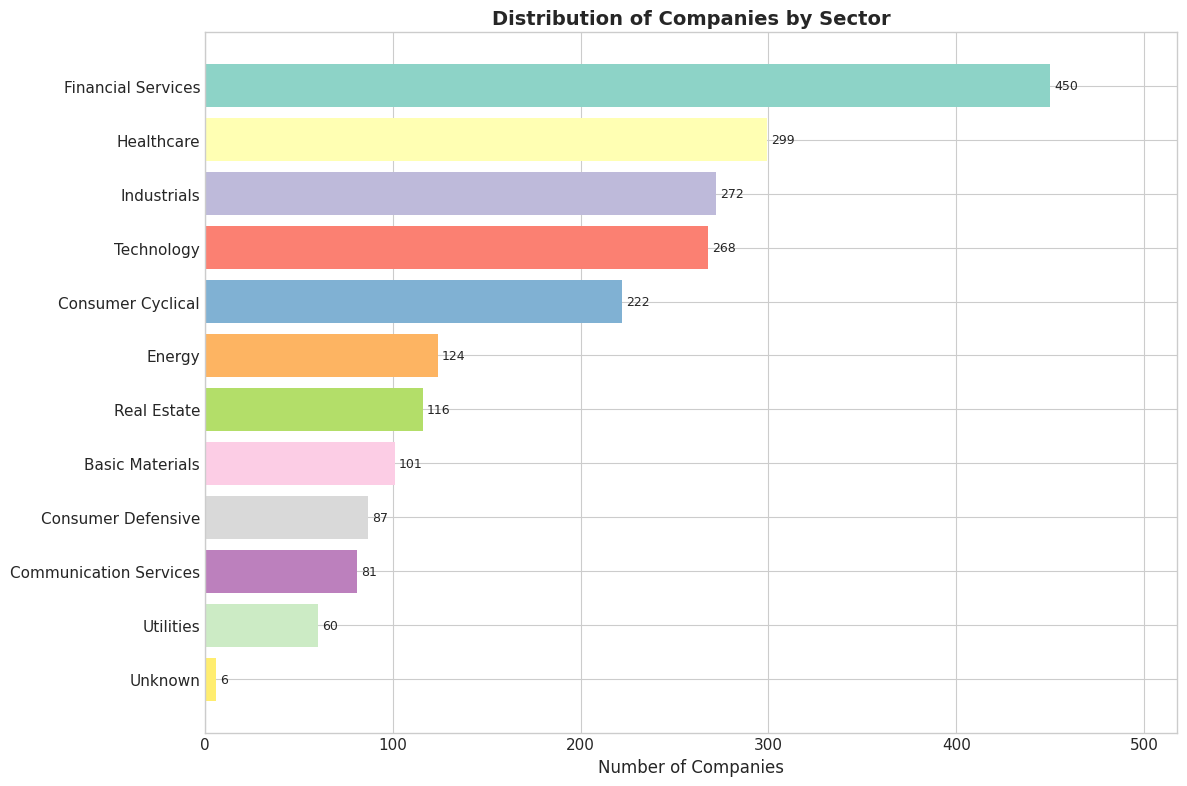

In [10]:
fig, ax = plt.subplots(figsize=(12, 8))
sector_counts = companies['sector'].fillna('Unknown').value_counts()
colors_sector = plt.cm.Set3(np.linspace(0, 1, len(sector_counts)))

bars = ax.barh(sector_counts.index[::-1], sector_counts.values[::-1], color=colors_sector[::-1])
ax.set_xlabel('Number of Companies')
ax.set_title('Distribution of Companies by Sector', fontweight='bold')
ax.bar_label(bars, padding=3, fontsize=9)
ax.set_xlim(0, max(sector_counts.values) * 1.15)

plt.tight_layout()
plt.show()

### Chart 2: Distribution of News Count Across Companies

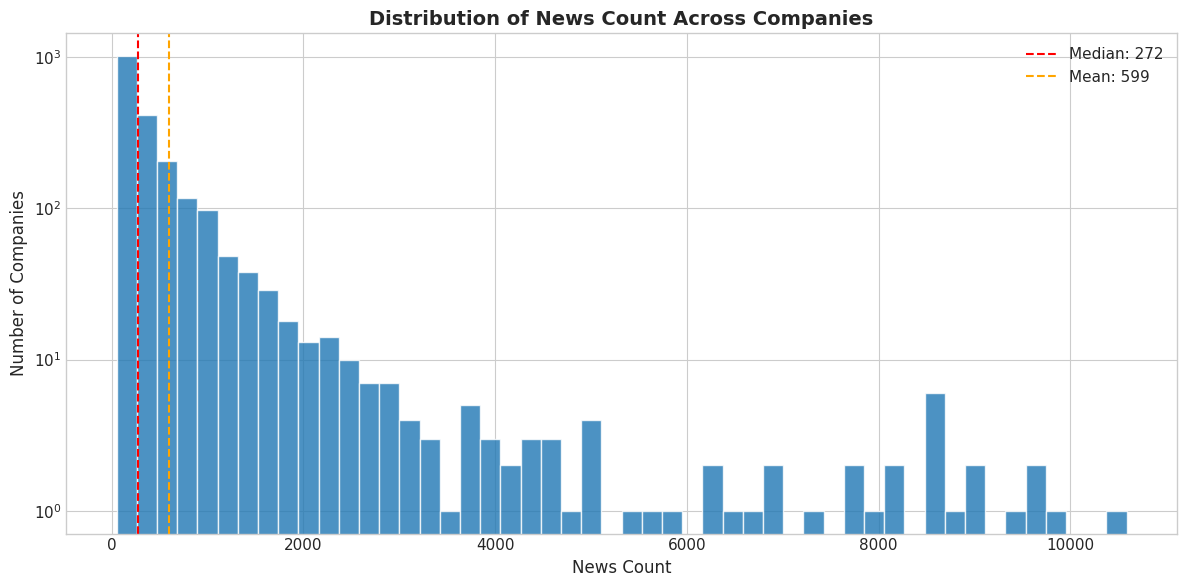

In [11]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(companies['news_count'], bins=50, edgecolor='white', alpha=0.8)

ax.axvline(companies['news_count'].median(), color='red', linestyle='--',
           label=f'Median: {companies["news_count"].median():.0f}')
ax.axvline(companies['news_count'].mean(), color='orange', linestyle='--',
           label=f'Mean: {companies["news_count"].mean():.0f}')

ax.set_xlabel('News Count')
ax.set_ylabel('Number of Companies')
ax.set_title('Distribution of News Count Across Companies', fontweight='bold')
ax.legend()
ax.set_yscale('log')

plt.tight_layout()
plt.show()

### Chart 3: Top 30 Companies by News Coverage

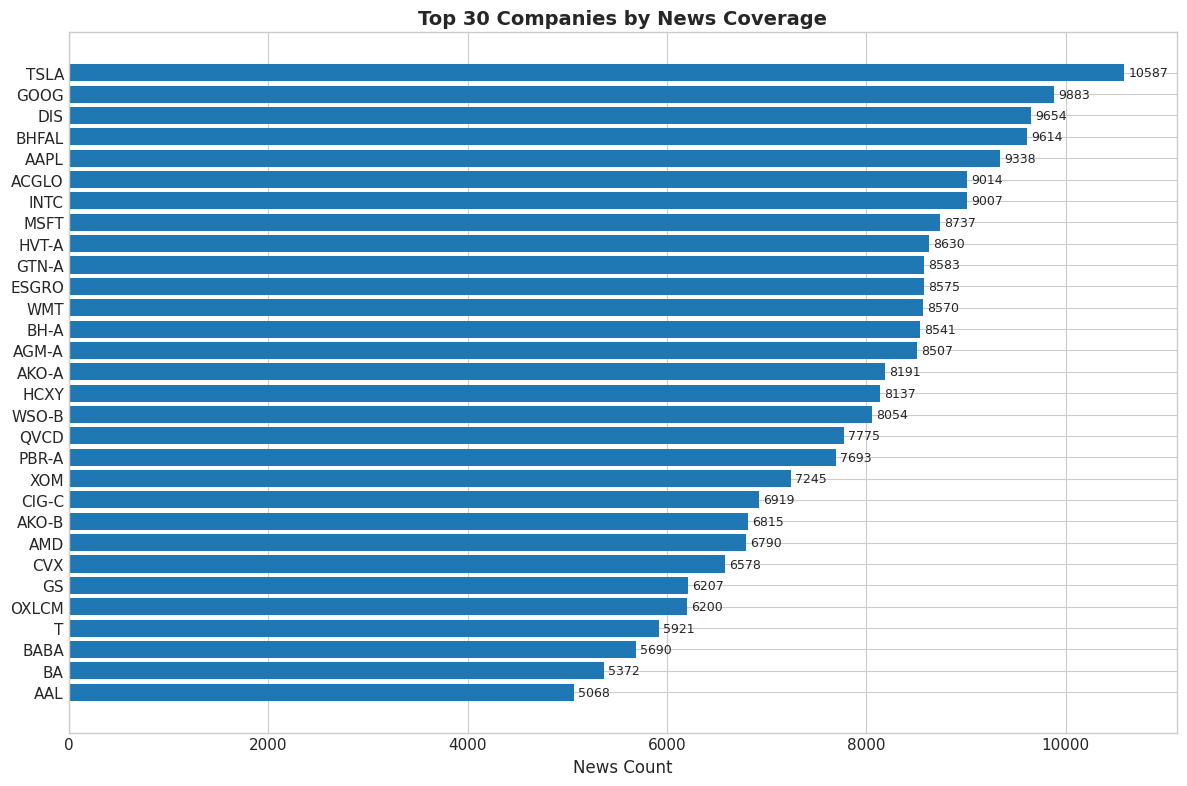

In [12]:
fig, ax = plt.subplots(figsize=(12, 8))
top30 = companies.nlargest(30, 'news_count')[['ticker', 'news_count']]
bars = ax.barh(range(len(top30)), top30['news_count'].values)

ax.set_yticks(range(len(top30)))
ax.set_yticklabels(top30['ticker'].values)
ax.set_xlabel('News Count')
ax.set_title('Top 30 Companies by News Coverage', fontweight='bold')
ax.invert_yaxis()
ax.bar_label(bars, padding=3, fontsize=9)

plt.tight_layout()
plt.show()

### Chart 4: News Distribution by Sector (Top 10)

/var/folders/40/q550qlmj2939zzyhq2_61n7c0000gn/T/ipykernel_34164/4153290697.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")


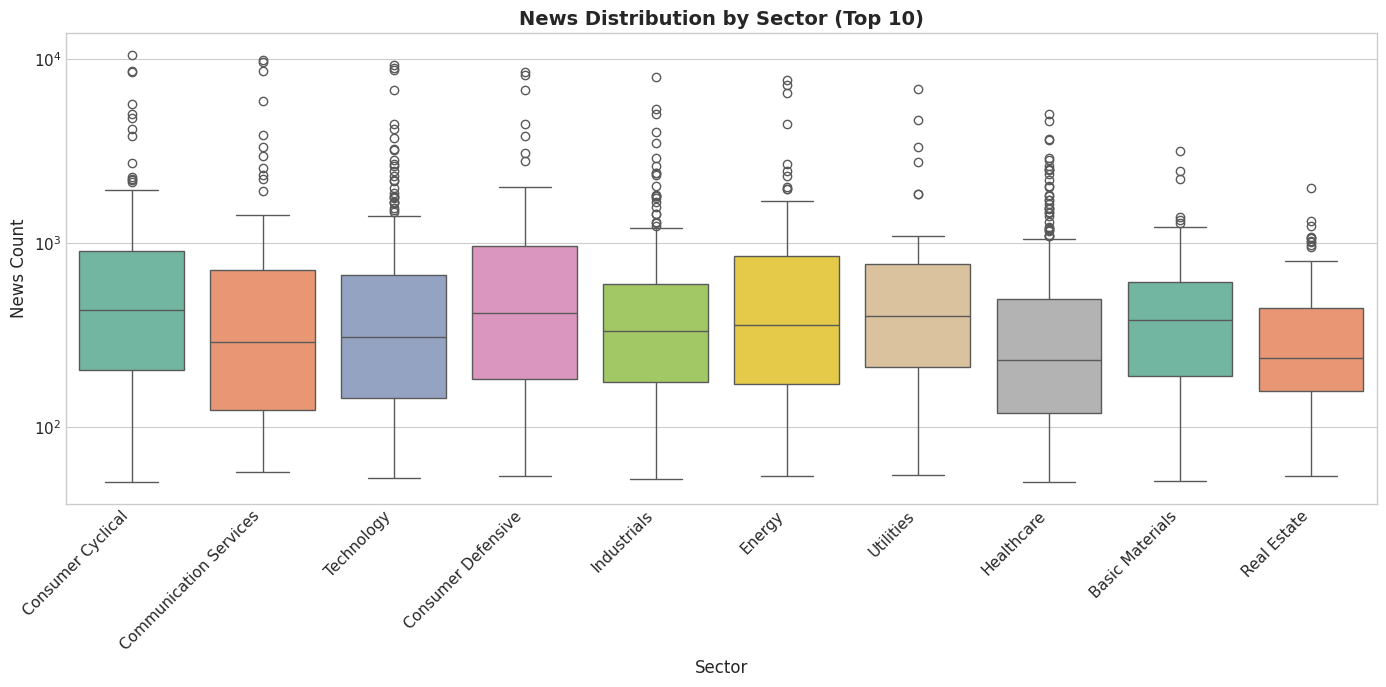

In [13]:
fig, ax = plt.subplots(figsize=(14, 7))

companies_plot = companies.copy()
companies_plot["sector_clean"] = companies_plot["sector"].fillna("Unknown")

tmp = companies_plot[companies_plot["sector_clean"] != "Unknown"]
sector_order = tmp.groupby("sector_clean")["news_count"].median().sort_values(ascending=False).index

top10_sectors = sector_order[:10]
companies_plot = companies_plot[companies_plot["sector_clean"].isin(top10_sectors)]

sns.boxplot(data=companies_plot, x="sector_clean", y="news_count", hue="sector_clean", palette="Set2", legend=False, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.set_yscale("log")
ax.set_xlabel("Sector")
ax.set_ylabel("News Count")
ax.set_title("News Distribution by Sector (Top 10)", fontweight="bold")

plt.tight_layout()
plt.show()

### Chart 5: Price Coverage vs. News Volume

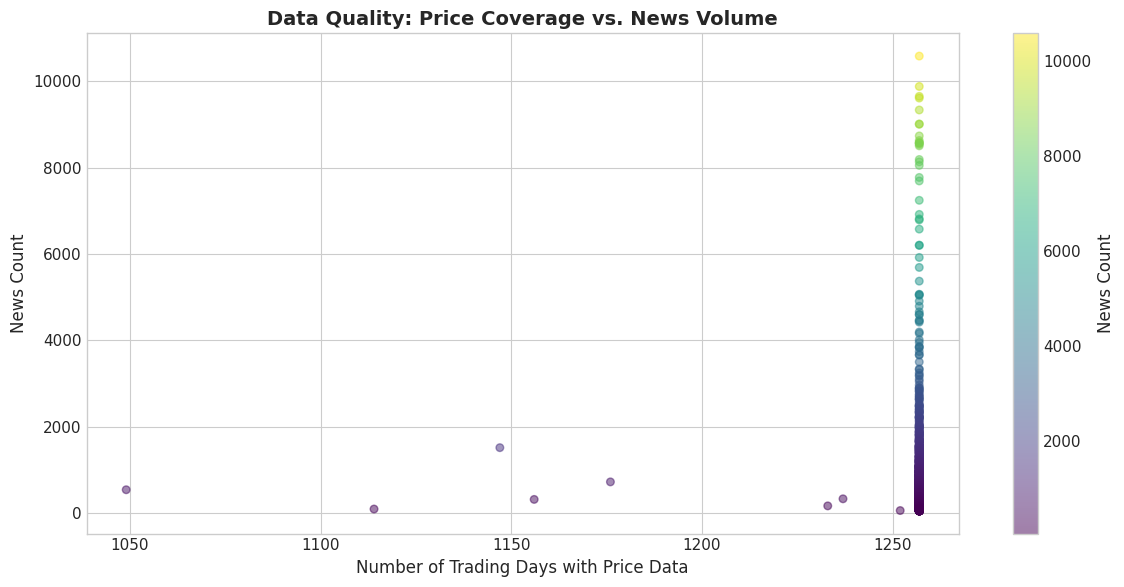

In [14]:
fig, ax = plt.subplots(figsize=(12, 6))
sc = ax.scatter(companies['price_rows'], companies['news_count'],
                alpha=0.5, c=companies['news_count'], cmap='viridis', s=30)

ax.set_xlabel('Number of Trading Days with Price Data')
ax.set_ylabel('News Count')
ax.set_title('Data Quality: Price Coverage vs. News Volume', fontweight='bold')
plt.colorbar(sc, ax=ax, label='News Count')

plt.tight_layout()
plt.show()

### Chart 6: Liquidity vs. Long-Term Price Variability

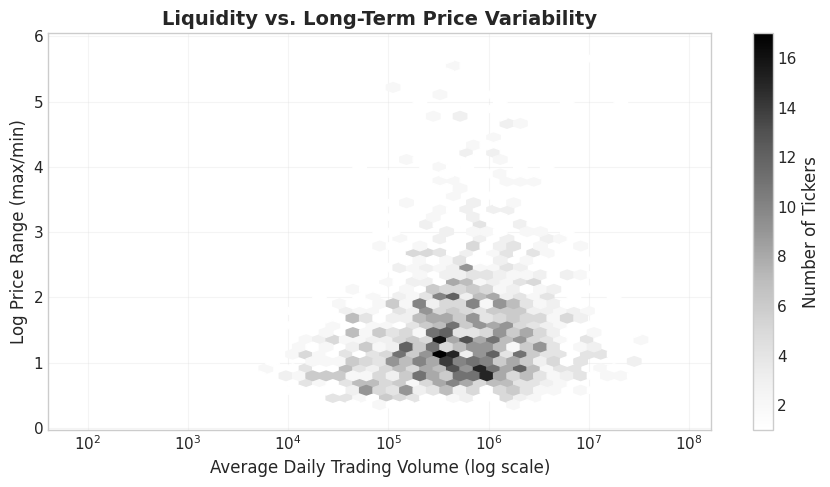

In [15]:
if len(summary_df) == 0:
    print("WARNING: summary_df is empty, skipping chart.")
else:
    dfp = summary_df.replace([np.inf, -np.inf], np.nan).dropna(
        subset=["min_price", "max_price", "avg_volume_per_day"]
    )
    dfp = dfp[(dfp["min_price"] > 0) & (dfp["max_price"] > 0)]
    dfp["log_price_range"] = np.log(dfp["max_price"]) - np.log(dfp["min_price"])

    y_max = dfp["log_price_range"].quantile(0.99)
    dfp_plot = dfp[dfp["log_price_range"] <= y_max]

    plt.figure(figsize=(9, 5))
    plt.hexbin(
        dfp_plot["avg_volume_per_day"],
        dfp_plot["log_price_range"],
        xscale="log",
        gridsize=45,
        mincnt=1
    )
    plt.xlabel("Average Daily Trading Volume (log scale)")
    plt.ylabel("Log Price Range (max/min)")
    plt.title("Liquidity vs. Long-Term Price Variability", fontweight="bold")
    plt.colorbar(label="Number of Tickers")
    plt.grid(True, alpha=0.2)
    plt.tight_layout()
    plt.show()

### Chart 7: Distribution of Average Daily Trading Volume

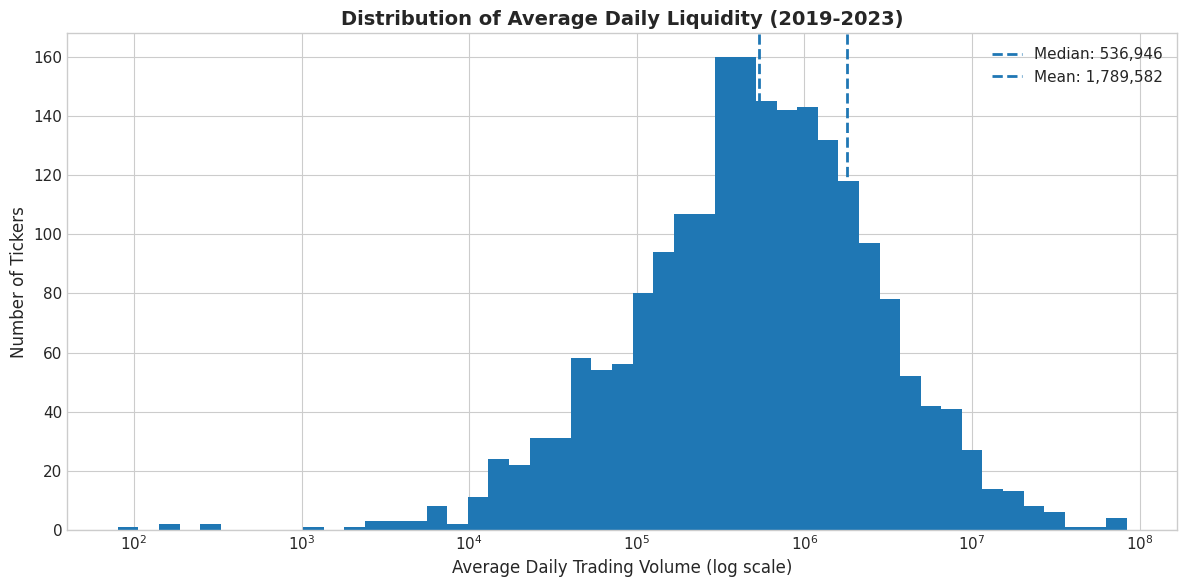

In [16]:
if len(summary_df) == 0:
    print("WARNING: summary_df is empty, skipping chart.")
else:
    vol = summary_df["avg_volume_per_day"].dropna()
    vol = vol[vol > 0]

    bins = np.logspace(np.log10(vol.min()), np.log10(vol.max()), 50)

    fig, ax = plt.subplots(figsize=(12, 6))
    ax.hist(vol, bins=bins)

    ax.set_xscale("log")
    ax.set_xlabel("Average Daily Trading Volume (log scale)")
    ax.set_ylabel("Number of Tickers")
    ax.set_title("Distribution of Average Daily Liquidity (2019-2023)", fontweight="bold")

    ax.axvline(np.median(vol), linestyle="--", linewidth=2,
               label=f"Median: {np.median(vol):,.0f}")
    ax.axvline(np.mean(vol), linestyle="--", linewidth=2,
               label=f"Mean: {np.mean(vol):,.0f}")
    ax.legend()

    plt.tight_layout()
    plt.show()

### Chart 8: Top 20 Most Active Tickers by Average Daily Volume

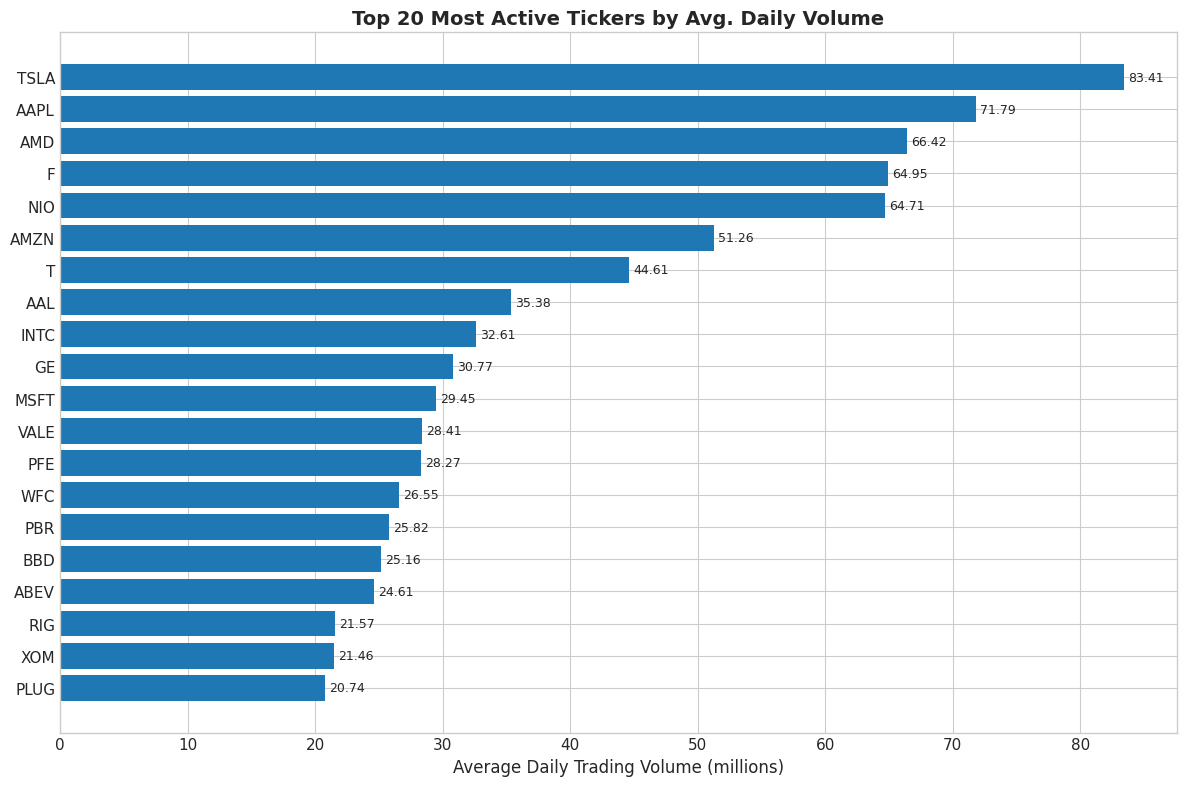

In [17]:
if len(summary_df) == 0:
    print("WARNING: summary_df is empty, skipping chart.")
else:
    fig, ax = plt.subplots(figsize=(12, 8))

    top20_vol = (
        summary_df.sort_values("avg_volume_per_day", ascending=False)
        .head(20)[["ticker", "avg_volume_per_day"]]
        .copy()
    )

    values_mln = top20_vol["avg_volume_per_day"].values / 1_000_000
    bars = ax.barh(range(len(top20_vol)), values_mln)

    ax.set_yticks(range(len(top20_vol)))
    ax.set_yticklabels(top20_vol["ticker"].values)
    ax.set_xlabel("Average Daily Trading Volume (millions)")
    ax.set_title("Top 20 Most Active Tickers by Avg. Daily Volume", fontweight="bold")
    ax.invert_yaxis()
    ax.bar_label(bars, padding=3, fontsize=9, fmt="%.2f")

    plt.tight_layout()
    plt.show()

### Chart 9: News Concentration Across Companies (Pareto Curve)

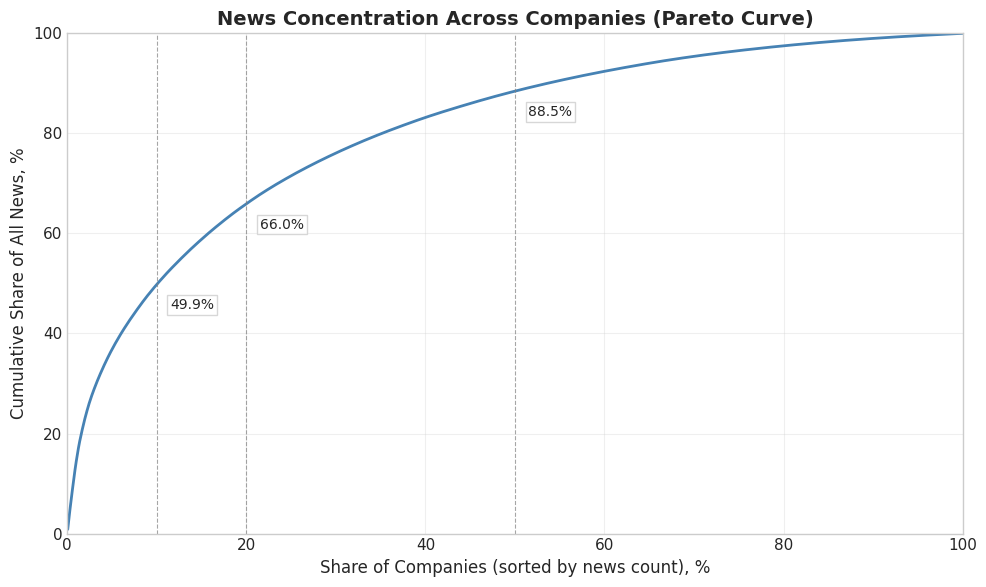

In [18]:
sorted_news = np.sort(companies['news_count'].values)[::-1]
cumsum = np.cumsum(sorted_news)
cumsum_pct = cumsum / cumsum[-1] * 100
companies_pct = np.arange(1, len(sorted_news) + 1) / len(sorted_news) * 100

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(companies_pct, cumsum_pct, color='steelblue', linewidth=2)

for pct in [10, 20, 50]:
    idx = min(int(len(sorted_news) * pct / 100), len(sorted_news) - 1)
    ax.axvline(pct, color='gray', linestyle='--', linewidth=0.8, alpha=0.7)
    ax.text(
        pct + 1.5,
        cumsum_pct[idx] - 5,
        f"{cumsum_pct[idx]:.1f}%",
        fontsize=10,
        bbox=dict(facecolor='white', edgecolor='lightgray', pad=2, alpha=0.9)
    )

ax.set_xlabel("Share of Companies (sorted by news count), %")
ax.set_ylabel("Cumulative Share of All News, %")
ax.set_title("News Concentration Across Companies (Pareto Curve)", fontweight="bold")
ax.set_xlim(0, 100)
ax.set_ylim(0, 100)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("fig_news_concentration.png", dpi=300, bbox_inches="tight")
plt.show()

### Chart 10: Sample Summary Statistics

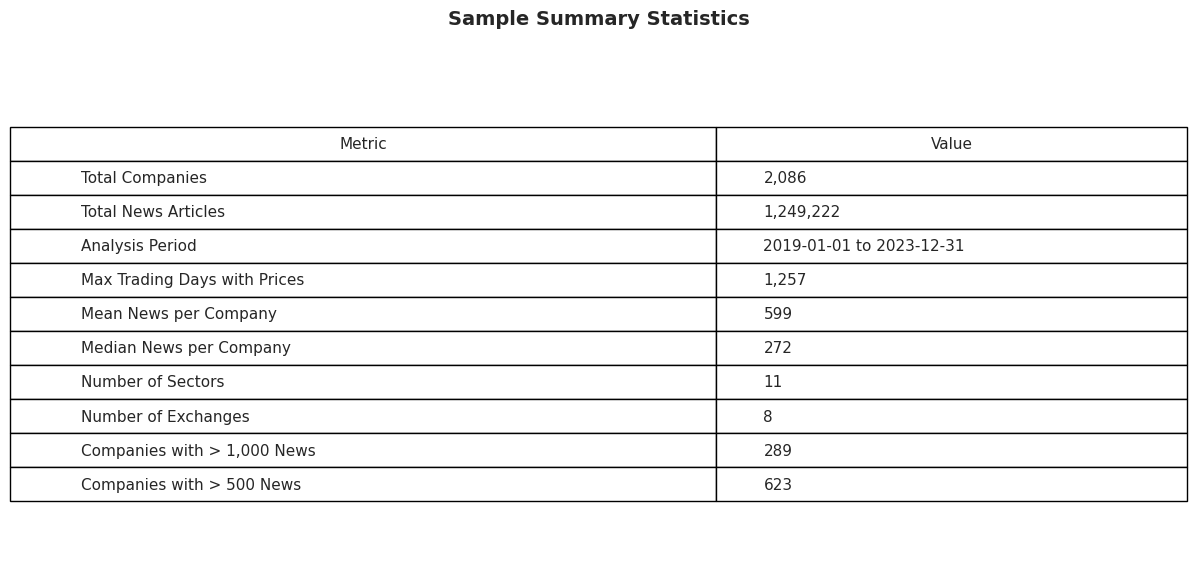

In [19]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.axis('off')

summary_data = [
    ['Total Companies', f'{len(companies):,}'],
    ['Total News Articles', f'{companies["news_count"].sum():,}'],
    ['Analysis Period', '2019-01-01 to 2023-12-31'],
    ['Max Trading Days with Prices', f'{companies["price_rows"].max():,}'],
    ['Mean News per Company', f'{companies["news_count"].mean():,.0f}'],
    ['Median News per Company', f'{companies["news_count"].median():,.0f}'],
    ['Number of Sectors', f'{companies["sector"].nunique()}'],
    ['Number of Exchanges', f'{companies["exchange"].nunique()}'],
    ['Companies with > 1,000 News', f'{(companies["news_count"] > 1000).sum():,}'],
    ['Companies with > 500 News', f'{(companies["news_count"] > 500).sum():,}']
]

table = ax.table(cellText=summary_data,
                 colLabels=['Metric', 'Value'],
                 cellLoc='left', loc='center',
                 colWidths=[0.6, 0.4])

table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1.2, 1.8)
ax.set_title('Sample Summary Statistics', fontweight='bold', pad=20)

plt.tight_layout()
plt.show()